# An Introduction to Quantile Regression
__Date__: Fall 2022 <br>
__Author__: Alex Parker

This notebook borrows heavily from the __[Medium blog post](https://towardsdatascience.com/mean-vs-median-causal-effect-37057a6c54c9)__ by Metteo Courthoud 

#### Quantile Regression Pros:
1. Can be more informative than OLS by showing impact on the entire distribution
2. Useful for highly skewed data that may have a large proportion of 0 values
3. Can be used to show effects at different quantiles
4. More robust to outliers than OLS


#### Quantile Regression Cons:
1. median analysis does not translate well to estimated a total business impact number
2. Assumes rank invariance: the ranks of the observations do not change as a result of an intervention

#### Interpretation
Under the asusmption of rank invariance the interpretation for a QR coefficient is the estimated effect of a single observation at the appropriate qunatile. Simply put, this means that if a QR is run on the 50th percentile of customers, then the coefficients represent the estimated effects of the covariates on the median customer.



In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

sns.set_theme(context = 'notebook', style = 'whitegrid')

In [2]:
### Set the renderer to 'svg' or 'png' for static images (visible in github) or 'vscode' for interactive (not viisble in github)
#plotly_renderer = 'svg'
plotly_renderer = 'vscode'

if plotly_renderer in ['svg','png']:
    print("You've chosen static images for plotly data visualizations, these should display in github")
elif plotly_renderer == 'vscode':
    print("You've chosen vscode for the ploltly renderer, these images will not display in github but will be animated in a VScode notebook environment")
else:
     print("please choose an appropriate plotly image renderer")

You've chosen vscode for the ploltly renderer, these images will not display in github but will be animated in a VScode notebook environment


In [3]:
def smf_results_to_df(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    p_value = results.pvalues
    coeff = results.params
    std_err = results.bse
    conf_lb = results.conf_int()[0]
    conf_ub = results.conf_int()[1]

    results_df = pd.DataFrame({"p_value":p_value,
                               "coeff":coeff,
                               "std_err":std_err,
                               "conf_lb":conf_lb,
                               "conf_ub":conf_ub
                                })

    #Reordering...
    results_df = results_df[["coeff","std_err","p_value","conf_lb","conf_ub"]]
    return results_df

### Data Generation: Randomized Experiment with some demographic information

In [4]:
n = 10000

# personal characteristics
age = np.random.randint(18, 70, n)
gender = np.random.choice(['male', 'female','other'], p=[0.51, 0.41,.08], size= n)
income = np.random.lognormal(4 + np.log(age), 0.1, n)

# treatment status
treatment = np.random.choice(['control','treatment'],p =[.5,.5], size = n)

# Dependant variable
spend = 50*(gender=='female') + 25*(gender == 'other') + (income/10)*np.random.normal(loc = 1, scale = .1, size = n) + (treatment == 'treatment')*np.sqrt(income)
spend = np.maximum(np.round(spend, 2) - 250, 0)

# Generate the dataframe
df = pd.DataFrame({'spend':spend,'treatment': treatment, 'age': age, 'gender': gender,'income':income})
df = df.assign(
    treatment = df.treatment.astype('category'),
    gender = df.gender.astype('category'))

df.head()

,spend,treatment,age,gender,income
0,0.00,control,37,female,1897.434061
1,3.49,treatment,36,male,1898.904852
2,47.52,treatment,47,male,2206.323612
3,98.43,treatment,41,female,2299.960652
4,193.05,control,69,male,4356.590557


#### The dependent variable is highly skewed with a high degree of 0 values

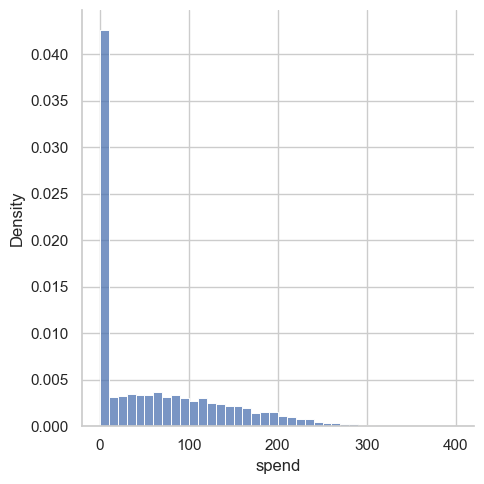

In [5]:
sns.displot(df, x = 'spend', stat = 'density')

In [6]:
df['spend'].describe(percentiles = [.1,.25,.5,.75,.9])

count    10000.000000
mean        61.445749
std         73.100774
min          0.000000
10%          0.000000
25%          0.000000
50%         32.350000
75%        108.502500
90%        171.967000
max        400.520000
Name: spend, dtype: float64

In [7]:
sample = df.sample(frac = .1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Scatterplots')

# Bulbasaur
sns.scatterplot(ax=axes[0], x=sample.age, y=sample.spend, hue = sample.treatment)
axes[0].set_title('Spend and Age')

# Charmander
sns.scatterplot(ax=axes[1], x=sample.income, y=sample.spend, hue = sample.treatment)
axes[1].set_title('Spend and Income')

# Squirtle
sns.scatterplot(ax=axes[2], x=sample.age, y=sample.income, hue = sample.treatment)
axes[2].set_title('Income and Age')

Text(0.5, 1.0, 'Income and Age')

In [8]:
### How is spend correlated with the categorical variables
sns.catplot(data = df, x = 'gender', y = 'spend', hue = 'treatment', kind = 'box')

In [9]:
df['spend_quantile'] = pd.qcut(df['spend'], q = 10,duplicates='drop', labels = [4,5,6,7,8,9,10])
df.head()


,spend,treatment,age,gender,income,spend_quantile
0,0.00,control,37,female,1897.434061,4
1,3.49,treatment,36,male,1898.904852,5
2,47.52,treatment,47,male,2206.323612,6
3,98.43,treatment,41,female,2299.960652,8
4,193.05,control,69,male,4356.590557,10


In [10]:
print(sns.__version__)

0.11.2


In [11]:
g = sns.catplot(data = df, x = 'spend_quantile', y = 'spend', hue = 'treatment', kind = 'box')
g.set_yscale('log')

#fig = px.box(df, x = 'spend_quantile', y = 'spend', color = 'treatment')
#fig.show()

AttributeError: 'FacetGrid' object has no attribute 'set_yscale'

## Analysis of the Causal Effect of Treatment

### Difference of means

In [ ]:
df.groupby('treatment')['spend'].agg(['count','mean','median','std'])

,count,mean,median,std
treatment,,,,
control,5023,44.140792,4.90,60.695654
treatment,4977,48.475176,14.72,62.750488


### OLS

In [ ]:
smf.ols("spend ~ treatment", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,44.1408,0.871,50.681,0.000,42.434,45.848
treatment[T.treatment],4.3344,1.235,3.511,0.000,1.914,6.754


In [ ]:
smf.ols("spend ~ treatment + age + gender", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-78.0103,1.269,-61.460,0.000,-80.498,-75.522
treatment[T.treatment],3.2689,0.745,4.389,0.000,1.809,4.729
gender[T.male],-26.8414,0.782,-34.311,0.000,-28.375,-25.308
gender[T.other],-15.5459,1.416,-10.977,0.000,-18.322,-12.770
age,3.1647,0.025,127.852,0.000,3.116,3.213


### Quantile Regression

In [ ]:
smf.quantreg("spend ~ treatment", data=df).fit(q = .5).summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.9000,0.469,10.458,0.000,3.982,5.818
treatment[T.treatment],9.8200,0.664,14.786,0.000,8.518,11.122


In [ ]:
smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5).summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-73.6641,1.355,-54.346,0.000,-76.321,-71.007
treatment[T.treatment],3.4080,0.822,4.147,0.000,1.797,5.019
gender[T.male],-22.9666,0.863,-26.605,0.000,-24.659,-21.274
gender[T.other],-12.8675,1.563,-8.234,0.000,-15.931,-9.804
income,0.0534,0.000,112.381,0.000,0.052,0.054


### Analysis of Effect at several different quantiles

In [ ]:
def plot_quantile_te(df, formula, q, varname):
    df_results = pd.DataFrame()
    for q in np.arange(q, 1-q, q):
        qreg = smf.quantreg(formula, data=df).fit(q=q)
        temp = pd.DataFrame({'q': [q],
                             'coeff': [qreg.params[varname]], 
                             'std': [qreg.bse[varname]],
                             'ci_lower': [qreg.conf_int()[0][varname]],
                             'ci_upper': [qreg.conf_int()[1][varname]]})
        df_results = pd.concat([df_results, temp]).reset_index(drop=True)
    
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(data=df_results, x='q', y='coeff')
    ax.fill_between(data=df_results, x='q', y1='ci_lower', y2='ci_upper', alpha=0.1);
    plt.axhline(y=0, c="k", lw=2, zorder=1)
    ols_coeff = smf.ols(formula, data=df).fit().params[varname]
    plt.axhline(y=ols_coeff, ls="--", c="C1", label="OLS coefficient", zorder=1)
    plt.legend()
    plt.title("Estimated coefficient, by quantile")

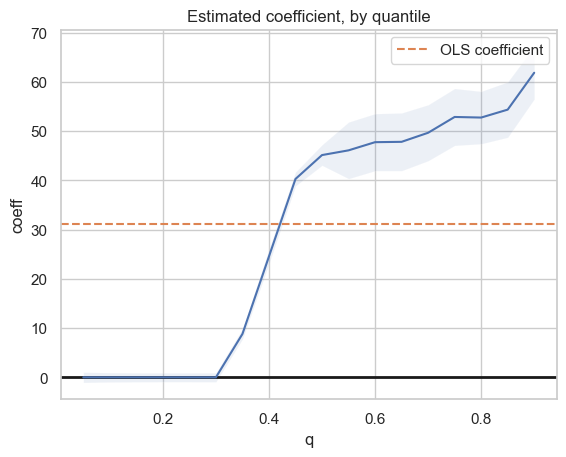

In [ ]:
plot_quantile_te(df, formula = "spend ~ treatment",varname = 'treatment[T.treatment]', q = .05)

NameError: name 'df_results' is not defined

In [ ]:
smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                  spend   Pseudo R-squared:               0.4605
Model:                       QuantReg   Bandwidth:                       7.018
Method:                 Least Squares   Sparsity:                        82.18
Date:                Sat, 15 Oct 2022   No. Observations:                10000
Time:                        16:45:41   Df Residuals:                     9995
                                        Df Model:                            4
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -73.6641      1.355    -54.346      0.000     -76.321     -71.007
treatment[T.treatment]     3.4080      0.822      4.147      0.000       1.797       5.019
gender[T.male]           -22.9666      0.863    -26.605      0.000     -24.659     -21.274
gender[T.other]          -12.8675      1.563     -8.234      0.000     -15.931      -9.804
income                     0.0534      0.000    112.381      0.000       0.052       0.054
==========================================================================================

The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results = smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5)

results.params

Intercept                -73.664080
treatment[T.treatment]     3.408018
gender[T.male]           -22.966628
gender[T.other]          -12.867518
income                     0.053404
dtype: float64

In [ ]:
results.pvalues

Intercept                  0.000000e+00
treatment[T.treatment]     3.403530e-05
gender[T.male]            9.750256e-151
gender[T.other]            2.032196e-16
income                     0.000000e+00
dtype: float64

In [ ]:
a = smf_results_to_df(results)
a

,coeff,std_err,p_value,conf_lb,conf_ub
Intercept,-73.664080,1.355464,0.000000e+00,-76.321063,-71.007097
treatment[T.treatment],3.408018,0.821898,3.403530e-05,1.796932,5.019103
gender[T.male],-22.966628,0.863250,9.750256e-151,-24.658773,-21.274483
gender[T.other],-12.867518,1.562676,2.032196e-16,-15.930677,-9.804360
income,0.053404,0.000475,0.000000e+00,0.052472,0.054335


In [13]:
def run_quantile_regressions(df, formula, q, varname):
    # Function runs multiple quantile regressions and returns a dataframe with the results for a selected vareter of interest
    # Arguments:
        # df: dataframe
        # formula: regression equation you wish to use, example "spend ~ treatment + gender"
        # q: The space between each quantile regression i.e. q=.1 would be every decile
        # varname: The variable in the regression equation whose estimated parameter you wish to return example: "gender"   
    all_qr_results = pd.DataFrame()
    for q in np.arange(q, 1-q, q):
        qreg = smf.quantreg(formula, data=df).fit(q=q)
        temp = pd.DataFrame({'coefficient':varname,
                             'q': [q],
                             'coeff': [qreg.vars[varname]], 
                             'std': [qreg.bse[varname]],
                             'p_value':[qreg.pvalues[varname]],
                             'ci_lower': [qreg.conf_int()[0][varname]],
                             'ci_upper': [qreg.conf_int()[1][varname]]})
        all_qr_results = pd.concat([all_qr_results, temp]).reset_index(drop=True)
    return(all_qr_results)



In [14]:
qrs = run_quantile_regressions(df, formula = "spend ~ treatment + gender + income", varname = "treatment[T.treatment]", q = .05)
qrs

,coefficient,q,coeff,std,p_value,ci_lower,ci_upper
0,treatment[T.treatment],0.05,21.275586,0.656759,5.245641e-219,19.988206,22.562967
1,treatment[T.treatment],0.10,26.342845,0.697556,7.278226e-292,24.975495,27.710196
2,treatment[T.treatment],0.15,28.580328,0.667602,0.000000e+00,27.271693,29.888962
3,treatment[T.treatment],0.20,28.804943,0.681469,0.000000e+00,27.469125,30.140760
4,treatment[T.treatment],0.25,29.323331,0.712882,0.000000e+00,27.925939,30.720723
5,treatment[T.treatment],0.30,30.045404,0.746920,0.000000e+00,28.581290,31.509518
6,treatment[T.treatment],0.35,30.714304,0.776505,0.000000e+00,29.192197,32.236410
7,treatment[T.treatment],0.40,30.095380,0.780372,1.849686e-303,28.565694,31.625066
8,treatment[T.treatment],0.45,30.470751,0.810510,1.990432e-289,28.881988,32.059515
9,treatment[T.treatment],0.50,30.013902,0.851824,1.848541e-256,28.344155,31.683649


Text(0.5, 1.0, 'Estimated coefficient, by quantile')

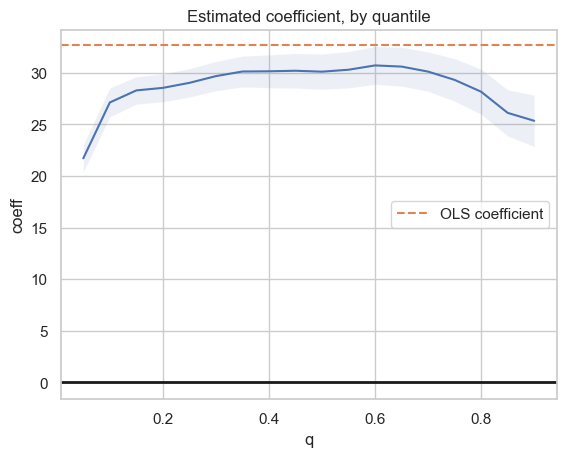

In [ ]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(data=qrs, x='q', y='coeff')
ax.fill_between(data=qrs, x='q', y1='ci_lower', y2='ci_upper', alpha=0.1);
plt.axhline(y=0, c="k", lw=2, zorder=1)
ols_coeff = smf.ols("spend ~ treatment + gender + income", data=df).fit().params["treatment[T.treatment]"]
plt.axhline(y=ols_coeff, ls="--", c="C1", label="OLS coefficient", zorder=1)
plt.legend()
plt.title("Estimated coefficient, by quantile")